In [1]:
devtools::load_all(".")
library(ggplot2); theme_set(theme_classic(base_size=14))
library(ggExtra)
library(dplyr)
library(patchwork)

options(repr.plot.res = 200)

ℹ Loading calpred

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
n_indiv <- 50000

set.seed(1234)

data <- simulate_example(n_indiv=n_indiv)
cal_data <- data[1:10000, ]
test_data <- data[10001:n_indiv, ]

# Example analysis for individual-level trait
Next we present an example workflow for analyzing trait.

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


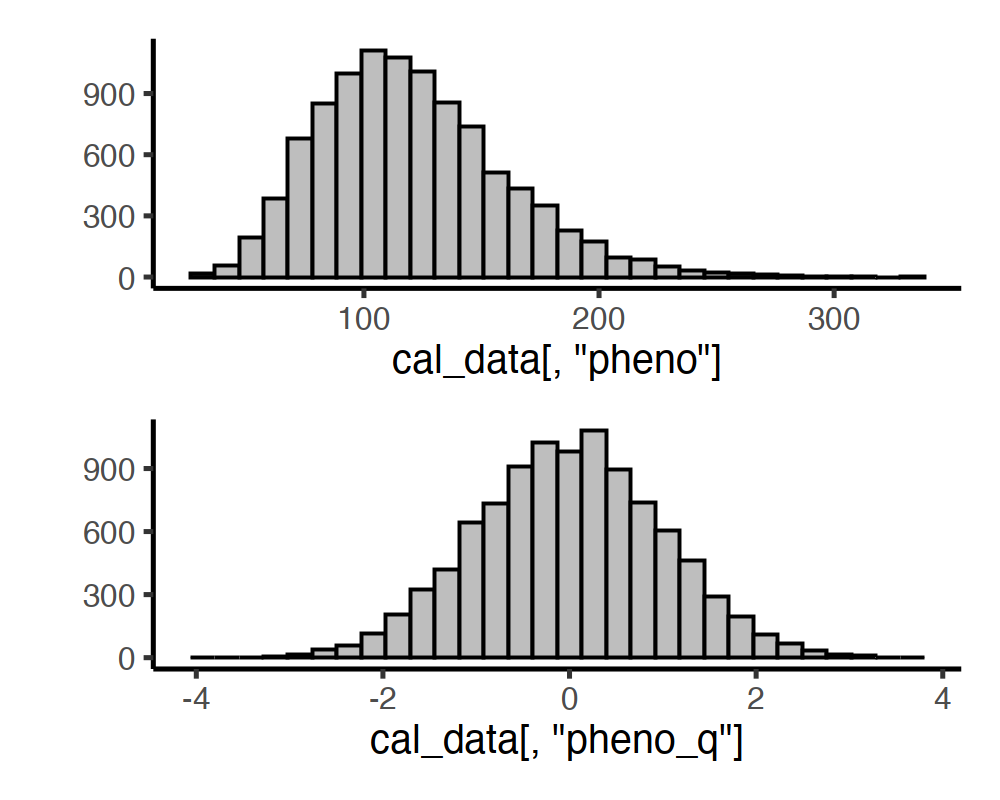

In [3]:
# build reference to convert quantile <-> value using the calibration dataset
qref <- normalize_reference(cal_data[, 'pheno']) 
cal_data['pheno_q'] <- qref$x2q(cal_data[, "pheno"])
test_data['pheno_q'] <- qref$x2q(test_data[, 'pheno'])

options(repr.plot.width = 5, repr.plot.height = 4)

qplot(cal_data[, "pheno"], bins=30, fill=I("grey"), color=I("black")) /
qplot(cal_data[, "pheno_q"], bins=30, fill=I("grey"), color=I("black"))

In [4]:
# use calibration data to train the model
mean_mat <- as.matrix(cal_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(cal_data[, c("intercept", "ancestry", "age", "sex")])
y <- cal_data[, 'pheno_q']
fit <- train(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    y=y
)

# use calibration data to train the model
mean_mat <- as.matrix(test_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(test_data[, c("intercept", "ancestry", "age", "sex")])
pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)
pred <- pred %>%
    rowwise() %>%
    mutate(
        point = qref$q2x(mean), 
        low = qref$q2x(mean - sd * 1.645), 
        high = qref$q2x(mean + sd * 1.645)
    )
test_data <- data.frame(test_data, pred)

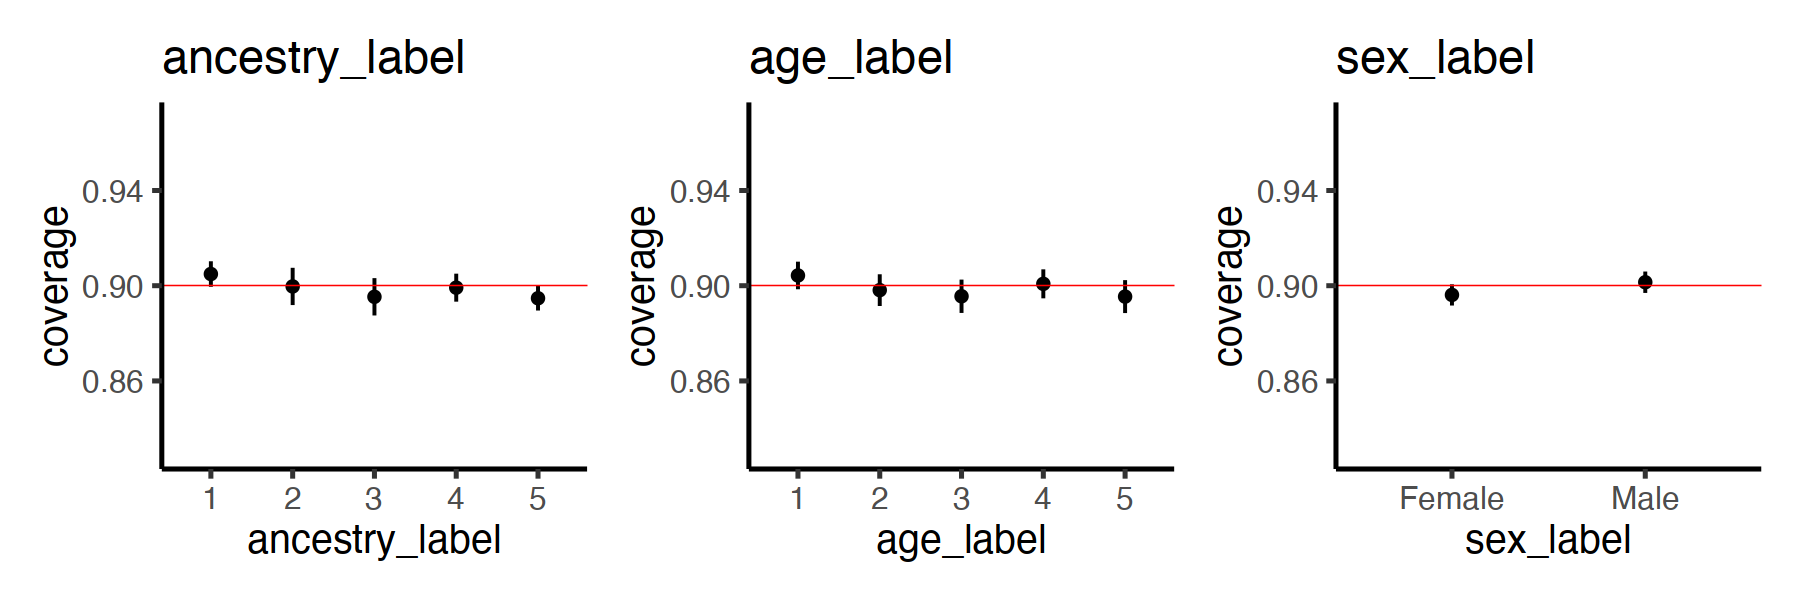

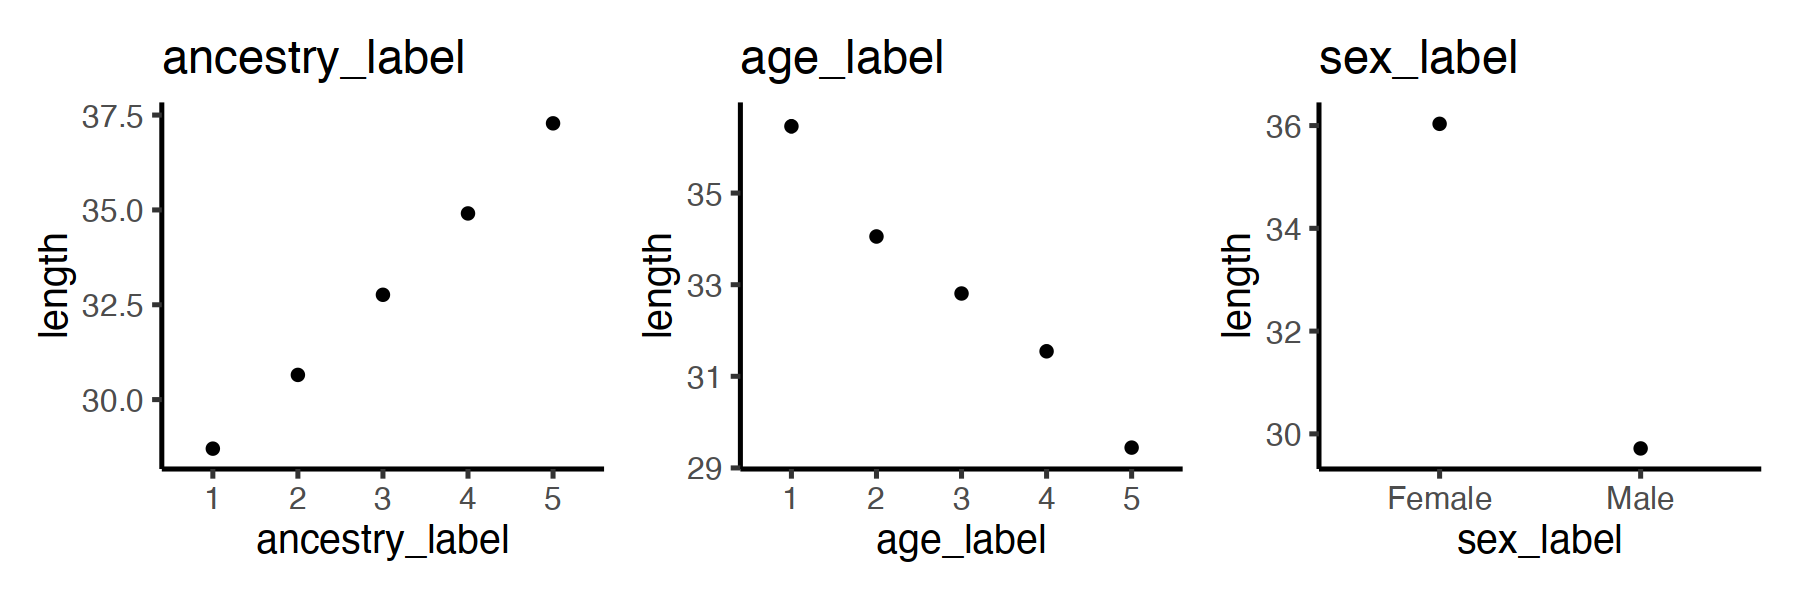

In [5]:
coverage_plots <- list()
length_plots <- list()
for (context in c("ancestry_label", "age_label", "sex_label")) {
        
    stats <- compute_stats(
        y=test_data[, 'pheno'], 
        pred=pred$mean, 
        predlow=pred$low, 
        predhigh=pred$high, 
        group=test_data[, context]
    )
    
    coverage_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'coverage') + 
          labs(title = context, x=context) +
          ylim(0.83, 0.97) + geom_hline(yintercept=0.9, color = "red", linewidth=0.2)
    
    length_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'length') + 
          labs(title = context, x=context)

}

options(repr.plot.width = 9, repr.plot.height = 3)
wrap_plots(coverage_plots, ncol = 3)
wrap_plots(length_plots, ncol = 3)

In [6]:
test_data[order(test_data$sd)[1:5], ]

,yhat,intercept,ancestry,age,sex,ancestry_label,age_label,sex_label,y,pheno,pheno_q,mean,sd,point,low,high
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36558,0.7726636,1,-1.681603,3.378684,-0.9938489,1,5,Male,1.8659366,161,1.0175329,0.4129401,0.5056843,132.96223,100.34923,171.9685
46547,0.4397957,1,-1.172112,3.642357,-0.9938489,1,5,Male,-0.8697438,98,-0.4894827,0.2324742,0.5196382,125.12369,93.49865,164.1727
21913,-1.2509055,1,-1.655917,3.019639,-0.9938489,1,5,Male,-0.5483730,105,-0.2982662,-0.6841477,0.5204023,91.51453,66.66358,122.5074
11188,-0.5703067,1,-1.598611,3.000470,-0.9938489,1,5,Male,-1.6034111,85,-0.8841782,-0.3151578,0.5238713,104.42967,76.54646,138.3650
44672,0.5833130,1,-1.703870,2.766413,-0.9938489,1,5,Male,3.1407244,195,1.6823551,0.3102828,0.5278425,128.53935,95.60570,168.5258


In [7]:
test_data[order(test_data$sd, decreasing = TRUE)[1:5], ]

,yhat,intercept,ancestry,age,sex,ancestry_label,age_label,sex_label,y,pheno,pheno_q,mean,sd,point,low,high
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15617,-0.9740949,1,1.6747580,-3.196340,1.006169,5,1,Female,1.9853981,164,1.08369512,-0.5340735,1.340733,96.50677,40.43031,194.2853
22915,0.1161143,1,1.6547685,-3.000600,1.006169,5,1,Female,0.4126951,125,0.22921733,0.0569887,1.319204,118.18340,53.69919,225.8239
18474,0.2943588,1,0.8990467,-3.936318,1.006169,4,1,Female,-1.4335745,88,-0.79347694,0.1536249,1.318652,121.74689,55.68651,232.0208
13442,-0.6199449,1,1.6904665,-2.817993,1.006169,5,1,Female,-2.4310439,72,-1.33860284,-0.3420693,1.305902,103.44661,45.20178,201.5904
16424,-1.8496616,1,1.3886061,-3.192082,1.006169,5,1,Female,-0.0989219,114,-0.05467172,-1.0087663,1.305716,81.62337,33.62703,166.6838


# Visualizing individualized prediction